In [46]:
from tkinter import messagebox
from tkinter import *
from tkinter import simpledialog
import tkinter
from tkinter import filedialog
from tkinter.filedialog import askopenfilename
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import webbrowser
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [47]:
global filename
global X,Y
global dataset
global main
global text
global accuracy, precision, recall, fscore
global X_train, X_test, y_train, y_test
global classifier
global label_encoder, labels, columns, types, pca

In [48]:
main = tkinter.Tk()
main.title("Mitigating DDOS Attack In IOT Network Environment") #designing main screen
main.geometry("1300x1200")

''

In [49]:
def getLabel(name):
    label = -1
    for i in range(len(labels)):
        if name == labels[i]:
            label = i
            break
    return label

In [50]:
def uploadDataset():
    global filename, dataset, labels
    text.delete('1.0', END)
    filename = filedialog.askdirectory(initialdir=".")
    text.insert(END,filename+" loaded\n\n")
    df1 = pd.read_csv(filename+"/DrDOS_DNS.csv")
    df2 = pd.read_csv(filename+"/DrDOS_LDAP.csv")
    df3 = pd.read_csv(filename+"/DrDOS_MSSQL.csv")
    df4 = pd.read_csv(filename+"/DrDOS_NTP.csv")
    df5 = pd.read_csv(filename+"/DrDOS_NetBIOS.csv")
    df6 = pd.read_csv(filename+"/DrDOS_SNMP.csv")
    df7 = pd.read_csv(filename+"/DrDOS_SSDP.csv")
    df8 = pd.read_csv(filename+"/DrDOS_UDP.csv")
    df9 = pd.read_csv(filename+"/Syn.csv")
    df10 = pd.read_csv(filename+"/UDP_LAG.csv")
    dataset = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
    dataset = pd.concat(dataset)
    labels = np.unique(dataset['Label']).tolist()
    null_val = dataset[dataset.isna().any(axis = 1)]
    text.insert(END,str(dataset.head()))
    text.update_idletasks()
    attack = dataset.groupby('Label').size()
    attack.plot(kind="bar")
    plt.xlabel('DDOS Attacks')
    plt.ylabel('Number of Records')
    plt.title('Different Attacks found in dataset')
    plt.show()

In [51]:
def preprocessDataset():
    global dataset, label_encoder, X, Y, columns, types, pca
    global X_train, X_test, y_train, y_test
    text.delete('1.0', END)
    label_encoder = []
    columns = dataset.columns
    types = dataset.dtypes.values
    for i in range(len(types)):
        name = types[i]
        if name == 'object' and columns[i] != 'Label':
            le = LabelEncoder()
            dataset[columns[i]] = pd.Series(le.fit_transform(dataset[columns[i]].astype(str)))
            label_encoder.append(le)
            print(columns[i])
    dataset.fillna(0, inplace = True)
    Y = dataset['Label'].ravel()
    temp = []
    for i in range(len(Y)):
        temp.append(getLabel(Y[i]))
    temp = np.asarray(temp)
    Y = temp
    dataset = dataset.values
    X = dataset[:,0:dataset.shape[1]-1]
    #Here the dataset provided has inf values which are not categorized as NAN or Null 
    for i in X:
        for x in i:
            i[np.isinf(x)] = 0 
    #Here we replace the inf values with 0 so as to normalize the values
    X = normalize(X)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    print(np.unique(Y))
    text.insert(END,"Dataset after features processing & normalization\n\n")
    text.insert(END,str(X)+"\n\n")
    text.insert(END,"Total records found in dataset : "+str(X.shape[0])+"\n")
    text.insert(END,"Total features found in dataset: "+str(X.shape[1])+"\n\n")
    pca = PCA(n_components = 50)
    X = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    text.insert(END,"Dataset Train and Test Split\n\n")
    text.insert(END,"80% dataset records used to train ML algorithms : "+str(X_train.shape[0])+"\n")
    text.insert(END,"20% dataset records used to train ML algorithms : "+str(X_test.shape[0])+"\n")


In [52]:
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    text.insert(END,algorithm+" Accuracy  :  "+str(a)+"\n")
    text.insert(END,algorithm+" Precision : "+str(p)+"\n")
    text.insert(END,algorithm+" Recall    : "+str(r)+"\n")
    text.insert(END,algorithm+" FScore    : "+str(f)+"\n\n")
    text.update_idletasks()
    print(np.unique(predict))
    print(np.unique(y_test))
    conf_matrix = confusion_matrix(y_test, predict) 
    #plt.figure(figsize =(6, 6)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()


In [53]:
def runNaiveBayes():
    global X, Y, X_train, X_test, y_train, y_test
    global accuracy, precision,recall, fscore
    accuracy = []
    precision = []
    recall = []
    fscore = []
    text.delete('1.0', END)
    if os.path.exists('model/nb.txt'):
        with open('model/nb.txt', 'rb') as file:
            nb = pickle.load(file)
        file.close()        
    else:
        nb = GaussianNB() 
        nb.fit(X_train, y_train)
        with open('model/nb.txt', 'wb') as file:
            pickle.dump(nb, file)
        file.close()        
    predict = nb.predict(X_test)
    calculateMetrics("Naive Bayes", predict, y_test)


In [54]:
def runRandomForest():
    global classifier
    if os.path.exists('model/rf.txt'):
        with open('model/rf.txt', 'rb') as file:
            rf = pickle.load(file)
        file.close()        
    else:
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        with open('model/rf.txt', 'wb') as file:
            pickle.dump(rf, file)
        file.close()        
    predict = rf.predict(X_test)
    classifier = rf
    calculateMetrics("Random Forest", predict, y_test)


In [55]:
def runSVM():
    if os.path.exists('model/svm.txt'):
        with open('model/svm.txt', 'rb') as file:
            svm_cls = pickle.load(file)
        file.close()        
    else:
        svm_cls = svm.SVC() 
        svm_cls.fit(X_train, y_train)
        with open('model/svm.txt', 'wb') as file:
            pickle.dump(svm_cls, file)
        file.close() 
    predict = svm_cls.predict(X_test)
    calculateMetrics("SVM", predict, y_test)


In [56]:
def runXGBoost():
    if os.path.exists('model/xgb.txt'):
        with open('model/xgb.txt', 'rb') as file:
            xgb_cls = pickle.load(file)
        file.close()        
    else:
        xgb_cls = XGBClassifier()
        xgb_cls.fit(X_train, y_train)
        with open('model/xgb.txt', 'wb') as file:
            pickle.dump(xgb_cls, file)
        file.close() 
    predict = xgb_cls.predict(X_test)
    calculateMetrics("XGBoost", predict, y_test)


In [57]:
def runAdaBoost():
    if os.path.exists('model/adb.txt'):
        with open('model/adb.txt', 'rb') as file:
            adb_cls = pickle.load(file)
        file.close()        
    else:
        adb_cls = AdaBoostClassifier()
        adb_cls.fit(X_train, y_train)
        with open('model/adb.txt', 'wb') as file:
            pickle.dump(adb_cls, file)
        file.close() 
    predict = adb_cls.predict(X_test)
    calculateMetrics("AdaBoost", predict, y_test)


In [58]:
def runKNN():
    if os.path.exists('model/knn.txt'):
        with open('model/knn.txt', 'rb') as file:
            knn_cls = pickle.load(file)
        file.close()        
    else:
        knn_cls = KNeighborsClassifier(n_neighbors = 2) 
        knn_cls.fit(X_train, y_train)
        with open('model/knn.txt', 'wb') as file:
            pickle.dump(knn_cls, file)
        file.close() 
    predict = knn_cls.predict(X_test)
    calculateMetrics("KNN", predict, y_test)


In [59]:
def predict():
    global label_encoder, labels, columns, types, pca
    text.delete('1.0', END)
    filename = filedialog.askopenfilename(initialdir="testData")
    testData = pd.read_csv(filename)
    count = 0
    for i in range(len(types)-1):
        name = types[i]
        if name == 'object':
            print(columns[i])
            if columns[i] == 'Flow Bytes/s':
                testData[columns[i]] = pd.Series(label_encoder[count].fit_transform(testData[columns[i]].astype(str)))
            else:
                testData[columns[i]] = pd.Series(label_encoder[count].transform(testData[columns[i]].astype(str)))
            count = count + 1            
    testData.fillna(0, inplace = True)
    testData = testData.values
    testData = normalize(testData)
    testData = pca.transform(testData)
    predict = classifier.predict(testData)
    print(predict)
    for i in range(len(predict)):
        text.insert(END,"Test DATA : "+str(testData[i])+" ===> PREDICTED AS "+labels[predict[i]]+"\n\n")


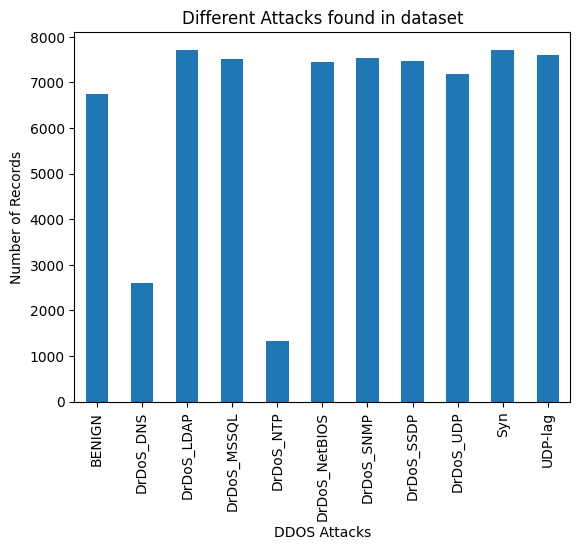

Flow ID
 Source IP
 Destination IP
 Timestamp
SimillarHTTP


C:\Users\markp\AppData\Local\Temp\ipykernel_3700\1943503766.py:16: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  Y = dataset['Label'].ravel()


[ 0  1  2  3  4  5  6  7  8  9 10]


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\markp\anaconda3\envs\myenv\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\markp\AppData\Local\Temp\ipykernel_3700\327343542.py", line 11, in runNaiveBayes
    nb = pickle.load(file)
_pickle.UnpicklingError: pickle data was truncated


In [60]:
def graph():
    output = "<html><body><table align=center border=1><tr><th>Algorithm Name</th><th>Accuracy</th><th>Precision</th><th>Recall</th>"
    output+="<th>FSCORE</th></tr>"
    output+="<tr><td>Naive Bayes Algorithm</td><td>"+str(accuracy[0])+"</td><td>"+str(precision[0])+"</td><td>"+str(recall[0])+"</td><td>"+str(fscore[0])+"</td></tr>"
    output+="<tr><td>Random Forest Algorithm</td><td>"+str(accuracy[1])+"</td><td>"+str(precision[1])+"</td><td>"+str(recall[1])+"</td><td>"+str(fscore[1])+"</td></tr>"
    output+="<tr><td>SVM Algorithm</td><td>"+str(accuracy[2])+"</td><td>"+str(precision[2])+"</td><td>"+str(recall[2])+"</td><td>"+str(fscore[2])+"</td></tr>"
    output+="<tr><td>XGBoost Algorithm</td><td>"+str(accuracy[3])+"</td><td>"+str(precision[3])+"</td><td>"+str(recall[3])+"</td><td>"+str(fscore[3])+"</td></tr>"
    output+="<tr><td>AdaBoostBoost Algorithm</td><td>"+str(accuracy[4])+"</td><td>"+str(precision[4])+"</td><td>"+str(recall[4])+"</td><td>"+str(fscore[4])+"</td></tr>"
    output+="<tr><td>KNN Algorithm</td><td>"+str(accuracy[5])+"</td><td>"+str(precision[5])+"</td><td>"+str(recall[5])+"</td><td>"+str(fscore[5])+"</td></tr>"
    output+="</table></body></html>"
    f = open("table.html", "w")
    f.write(output)
    f.close()
    webbrowser.open("table.html",new=2)
    
    df = pd.DataFrame([['Naive Bayes','Precision',precision[0]],['Naive Bayes','Recall',recall[0]],['Naive Bayes','F1 Score',fscore[0]],['Naive Bayes','Accuracy',accuracy[0]],
                       ['Random Forest','Precision',precision[1]],['Random Forest','Recall',recall[1]],['Random Forest','F1 Score',fscore[1]],['Random Forest','Accuracy',accuracy[1]],
                       ['SVM','Precision',precision[2]],['SVM','Recall',recall[2]],['SVM','F1 Score',fscore[2]],['SVM','Accuracy',accuracy[2]],
                       ['XGBoost','Precision',precision[3]],['XGBoost','Recall',recall[3]],['XGBoost','F1 Score',fscore[3]],['XGBoost','Accuracy',accuracy[3]],
                       ['AdaBoost','Precision',precision[4]],['AdaBoost','Recall',recall[4]],['AdaBoost','F1 Score',fscore[4]],['AdaBoost','Accuracy',accuracy[4]],
                       ['KNN','Precision',precision[5]],['KNN','Recall',recall[5]],['KNN','F1 Score',fscore[5]],['KNN','Accuracy',accuracy[5]],
                      ],columns=['Algorithms','Performance Output','Value'])
    df.pivot("Algorithms", "Performance Output", "Value").plot(kind='bar')
    plt.show()


font = ('times', 16, 'bold')
title = Label(main, text='Mitigating DDOS Attack In IOT Network Environment')
title.config(bg='greenyellow', fg='dodger blue')  
title.config(font=font)           
title.config(height=3, width=120)       
title.place(x=0,y=5)

font1 = ('times', 12, 'bold')
text=Text(main,height=20,width=150)
scroll=Scrollbar(text)
text.configure(yscrollcommand=scroll.set)
text.place(x=50,y=120)
text.config(font=font1)


font1 = ('times', 13, 'bold')
uploadButton = Button(main, text="Upload DDOS Dataset", command=uploadDataset)
uploadButton.place(x=50,y=550)
uploadButton.config(font=font1)  

preprocessButton = Button(main, text="Preprocess Dataset", command=preprocessDataset)
preprocessButton.place(x=330,y=550)
preprocessButton.config(font=font1) 

nbButton = Button(main, text="Run Naive Bayes Algorithm", command=runNaiveBayes)
nbButton.place(x=630,y=550)
nbButton.config(font=font1)

rfButton = Button(main, text="Run Random Forest Algorithm", command=runRandomForest)
rfButton.place(x=920,y=550)
rfButton.config(font=font1)

svmButton = Button(main, text="Run SVM Algorithm", command=runSVM)
svmButton.place(x=50,y=600)
svmButton.config(font=font1)

xgButton = Button(main, text="Run XGBoost Algorithm", command=runXGBoost)
xgButton.place(x=330,y=600)
xgButton.config(font=font1) 

adaboostButton = Button(main, text="Run AdaBoost Algorithm", command=runAdaBoost)
adaboostButton.place(x=630,y=600)
adaboostButton.config(font=font1)

knnButton = Button(main, text="Run KNN Algorithm", command=runKNN)
knnButton.place(x=920,y=600)
knnButton.config(font=font1)

graphButton = Button(main, text="Comparison Graph", command=graph)
graphButton.place(x=50,y=650)
graphButton.config(font=font1)

predictButton = Button(main, text="Predict Attack from Test Data", command=predict)
predictButton.place(x=330,y=650)
predictButton.config(font=font1) 


main.config(bg='LightSkyBlue')
main.mainloop()


x


In [29]:
types = dataset.dtypes.values